# MNIST CNN

# 1) Kütüphanelerin Projeye Dahil Edilmesi
Gerekli kütüphanelerin yüklenmesi.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix


# 2) Veri Setinin Yüklenmesi ve İlk Görüntünün Gösterilmesi
MNIST eğitim verisi okunur ve ilk örnek 28x28 piksel formatında görselleştirilir.


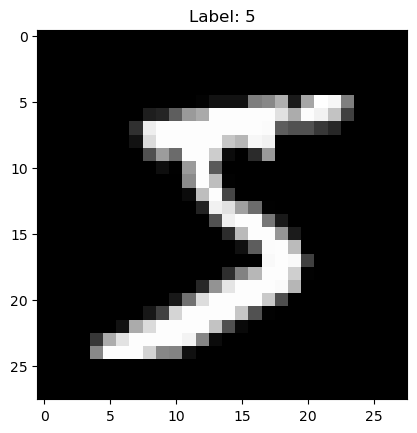

In [2]:
train = pd.read_csv('mnist_train.csv')
plt.imshow(train.iloc[0,1:].values.reshape(28,28), cmap='gray')
plt.title(f"Label: {train.iloc[0,0]}")
plt.show()

# 3) Veri Ön İşleme ve PyTorch Veri Yükleyicilerinin Hazırlanması
Görüntüler normalize edilir, 1×28×28 formatına getirilir; eğitim–doğrulama ayrımı yapılır ve DataLoader yapıları oluşturulur.


In [3]:
X = train.drop('label', axis=1).values.astype(np.float32) / 255.0
X = X.reshape(-1, 1, 28, 28)
y = train['label'].values.astype(np.int64)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_t = torch.tensor(X_train)
X_val_t = torch.tensor(X_val)
y_train_t = torch.tensor(y_train)
y_val_t = torch.tensor(y_val)
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128)

# 4) CNN Modelinin Tanımlanması ve Eğitim Bileşenlerinin Hazırlanması
Evrişim katmanları ve tam bağlantılı katmanlardan oluşan CNN modeli oluşturulur.


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(), nn.Linear(64*5*5, 128), nn.ReLU(), nn.Dropout(0.4), nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.cnn(x); x = self.fc(x); return x
model = CNN(); criterion = nn.CrossEntropyLoss(); optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5) CNN Modelinin Eğitilmesi
Model her epoch'ta eğitilir; eğitim ve doğrulama kayıp–doğruluk değerleri hesaplanarak takip edilir.


In [5]:
epochs = 10
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    for Xb, yb in train_dl:
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(preds, 1)
        correct += (predicted == yb).sum().item()
        total += yb.size(0)
        running_loss += loss.item() * yb.size(0)
    train_acc = correct / total
    train_loss = running_loss / total

    model.eval()
    correct = 0
    total = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for Xb, yb in val_dl:
            preds = model(Xb)
            loss = criterion(preds, yb)
            _, predicted = torch.max(preds, 1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
            val_running_loss += loss.item() * yb.size(0)
    val_acc = correct / total
    val_loss = val_running_loss / total

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    print(f'Epoch {epoch+1}: Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f} | Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f}')


Epoch 1: Train Acc=0.8952 | Val Acc=0.9743 | Train Loss=0.3428 | Val Loss=0.0821
Epoch 2: Train Acc=0.9711 | Val Acc=0.9833 | Train Loss=0.0947 | Val Loss=0.0581
Epoch 3: Train Acc=0.9786 | Val Acc=0.9865 | Train Loss=0.0718 | Val Loss=0.0441
Epoch 4: Train Acc=0.9831 | Val Acc=0.9880 | Train Loss=0.0567 | Val Loss=0.0399
Epoch 5: Train Acc=0.9852 | Val Acc=0.9876 | Train Loss=0.0486 | Val Loss=0.0415
Epoch 6: Train Acc=0.9872 | Val Acc=0.9894 | Train Loss=0.0409 | Val Loss=0.0357
Epoch 7: Train Acc=0.9889 | Val Acc=0.9893 | Train Loss=0.0342 | Val Loss=0.0425
Epoch 8: Train Acc=0.9892 | Val Acc=0.9913 | Train Loss=0.0335 | Val Loss=0.0349
Epoch 9: Train Acc=0.9907 | Val Acc=0.9898 | Train Loss=0.0294 | Val Loss=0.0379
Epoch 10: Train Acc=0.9915 | Val Acc=0.9902 | Train Loss=0.0251 | Val Loss=0.0388


# 6) Doğruluk Eğrisinin Çizilmesi
Eğitim ve doğrulama doğruluk değerleri epoch’lar boyunca görselleştirilir.


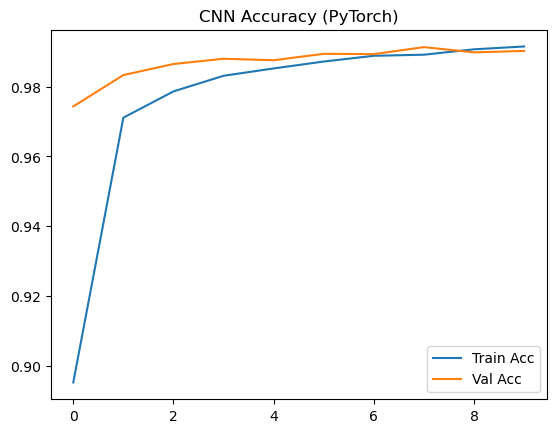

In [6]:
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.legend(); plt.title('CNN Accuracy (PyTorch)')
plt.show()

# 7) Kayıp Eğrisinin Çizilmesi
Eğitim ve doğrulama kayıp değerleri epoch’lara göre görselleştirilerek modelin öğrenme davranışı incelenir.



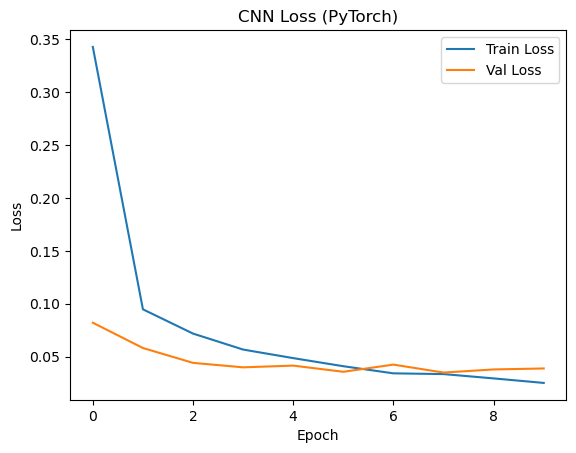

In [7]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend()
plt.title('CNN Loss (PyTorch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# 8) Rastgele Tahminlerin Görselleştirilmesi
Doğrulama setinden seçilen rastgele örnekler üzerinde modelin gerçek ve tahmin edilen etiketleri görsel olarak karşılaştırılır.


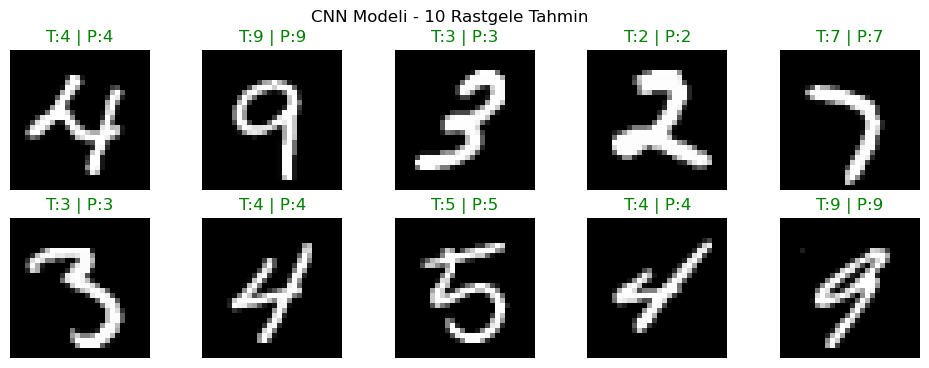

In [8]:
model.eval(); plt.figure(figsize=(12,4))
for i in range(10):
    idx = random.randint(0, len(X_val_t)-1)
    img = X_val_t[idx]; true_label = y_val_t[idx].item()
    with torch.no_grad():
        out = model(img.unsqueeze(0)); pred = torch.argmax(out, dim=1).item()
    plt.subplot(2,5,i+1)
    plt.imshow(img.squeeze().reshape(28,28), cmap='gray')
    plt.title(f'T:{true_label} | P:{pred}', color='green' if pred==true_label else 'red')
    plt.axis('off')
plt.suptitle('CNN Modeli - 10 Rastgele Tahmin')
plt.show()

# 9) Model Performansının Ölçülmesi
Doğrulama setindeki tüm örnekler için doğruluk, precision, recall ve F1 değerleri hesaplanır; sınıflandırma raporu ve karışıklık matrisi görüntülenir.


Validation Accuracy: 0.9902
Validation Precision (macro): 0.9902
Validation Recall (macro): 0.9902
Validation F1-score (macro): 0.9902

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1175
           1       0.99      1.00      0.99      1322
           2       0.98      0.99      0.98      1174
           3       1.00      0.98      0.99      1219
           4       0.99      0.99      0.99      1176
           5       0.99      0.98      0.99      1104
           6       0.99      1.00      0.99      1177
           7       0.99      0.99      0.99      1299
           8       0.99      0.99      0.99      1160
           9       0.99      0.99      0.99      1194

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000



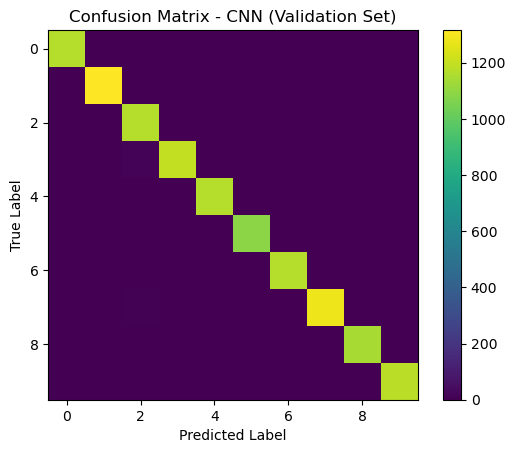

In [9]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for Xb, yb in val_dl:
        outputs = model(Xb)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(yb.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
print(f'Validation Accuracy: {acc:.4f}')
print(f'Validation Precision (macro): {precision:.4f}')
print(f'Validation Recall (macro): {recall:.4f}')
print(f'Validation F1-score (macro): {f1:.4f}')
print('\nClassification Report:')
print(classification_report(all_labels, all_preds))

cm = confusion_matrix(all_labels, all_preds)
plt.figure()
plt.imshow(cm)
plt.title('Confusion Matrix - CNN (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar()
plt.show()
